In [ ]:
!pip install nltk
!pip install pandas
!pip install textblob
!pip install scikit-learn
!pip install matplotlib

## Sentence Sentiment based rating prediction with added tweaks - Model 04 (Refer to the last model which is the ultimatum in our analysis)

In [149]:
import gzip
import pandas as pd
import goslate
import json
import requests

import nltk
import string
from nltk.stem.porter import *
from nltk.corpus import stopwords
nltk.download("stopwords")
from textblob import TextBlob

from sklearn import linear_model
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NUNNUN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Note**: Use cd .. or pwd commands to read the data files if required.

In [9]:
cd ..

E:\ASTUDY\HK-5\BIGDATA\rating-prediction-google-local


C:\Users\NUNNUN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [150]:
data_places = []
with gzip.open("data/places.clean.json.gz") as f:
    for l in f:
        data_places.append(eval(l))

In [13]:
len(data_places), data_places[:1]

(3114353,
 [{'name': 'Diamond Valley Lake Marina',
   'price': None,
   'address': ['2615 Angler Ave', 'Hemet, CA 92545'],
   'hours': [['Monday', [['6:30 am--4:15 pm']]],
    ['Tuesday', [['6:30 am--4:15 pm']]],
    ['Wednesday', [['6:30 am--4:15 pm']], 1],
    ['Thursday', [['6:30 am--4:15 pm']]],
    ['Friday', [['6:30 am--4:15 pm']]],
    ['Saturday', [['6:30 am--4:15 pm']]],
    ['Sunday', [['6:30 am--4:15 pm']]]],
   'phone': '(951) 926-7201',
   'closed': False,
   'gPlusPlaceId': '104699454385822125632',
   'gps': [33.703804, -117.003209]}])

In [157]:
N = 4000000
data_reviews = []
with gzip.open("data/reviews.clean.json.gz") as f:
    head = [next(f) for x in range(N)]
    # for l in f:
    #     data_reviews.append(eval(l))
    #print(head)

In [15]:
for l in head:
    data_reviews.append(eval(l))

In [19]:
len(data_reviews)

4000000

In [20]:
head = data_reviews
head[:1]

[b"{'rating': 3.0, 'reviewerName': u'an lam', 'reviewText': u'Ch\\u1ea5t l\\u01b0\\u1ee3ng t\\u1ea1m \\u1ed5n', 'categories': [u'Gi\\u1ea3i Tr\\xed - Caf\\xe9'], 'gPlusPlaceId': u'108103314380004200232', 'unixReviewTime': 1372686659, 'reviewTime': u'Jul 1, 2013', 'gPlusUserId': u'100000010817154263736'}\n"]

In [21]:
data_reviews[:1], len(data_reviews)

([{'rating': 3.0,
   'reviewerName': 'an lam',
   'reviewText': 'Chất lượng tạm ổn',
   'categories': ['Giải Trí - Café'],
   'gPlusPlaceId': '108103314380004200232',
   'unixReviewTime': 1372686659,
   'reviewTime': 'Jul 1, 2013',
   'gPlusUserId': '100000010817154263736'}],
 4000000)

In [152]:
df_data_reviews = pd.DataFrame.from_dict(data_reviews)

In [23]:
df_data_reviews[:5]

,rating,reviewerName,reviewText,categories,gPlusPlaceId,unixReviewTime,reviewTime,gPlusUserId
0,3.0,an lam,Chất lượng tạm ổn,[Giải Trí - Café],108103314380004200232,1.372687e+09,"Jul 1, 2013",100000010817154263736
1,5.0,HALİL TURGUT,Wc si temiz duzenli..,[Turkish Cuisine],102194128241608748649,1.342871e+09,"Jul 21, 2012",100000013500285534661
2,5.0,森田さとこ,何回も私は予定に休みがセルバに行ったので覚えて見て、分かります❗,"[Fishing, Pond Fish Supplier, Seafood Market]",101409858828175402384,1.390654e+09,"Jan 25, 2014",100000021336848867366
3,5.0,森田さとこ,今度は予定に休みが登米市に行きたい❗☀😅🌌 楽しいに日帰りに登米の見学の観光(*^)(*^-...,[Museum],101477177500158511502,1.389188e+09,"Jan 8, 2014",100000021336848867366
4,4.0,森田さとこ,気仙沼警察署に移転中に絆 👮🐎☺🙋🚓頑張ろう❗,[Police],106994170641063333085,1.390486e+09,"Jan 23, 2014",100000021336848867366


In [24]:
len(df_data_reviews)

4000000

In [153]:
df_reviews = df_data_reviews.dropna()

In [154]:
len(df_reviews), df_reviews.iloc[2536747]

IndexError: single positional indexer is out-of-bounds

In [22]:
# reviews_data = df_reviews.T.to_dict().values()

### Function - Filtering out data based on GPS coordinates

In [ ]:
def places_filter(dataset, lat_l, lat_h, lon_l, lon_h):
    reviews_us = []
    for d in dataset:
        if d["gps"] != None and d["price"] != None and d["price"] != "":
            if (
                (d["gps"][0] >= lat_l)
                & (d["gps"][0] <= lat_h)
                & (d["gps"][1] >= lon_l)
                & (d["gps"][1] <= lon_h)
            ):
                reviews_us.append(d)
    return reviews_us

In [ ]:
places_ca = places_filter(data_places, 32.32, 42, -124.26, -114.8)

In [29]:
len(places_ca), len(data_reviews)

(48865, 4000000)

### Function - Filter data based on

In [ ]:
def joined_data(places, reviews):
    placeGPS = defaultdict(list)
    placePrice = defaultdict(list)
    joined_data = []

    for d in places:
        placeGPS[d["gPlusPlaceId"]] = d["gps"]
        placePrice[d["gPlusPlaceId"]] = d["price"]
    # print(placeGPS)
    # dataset is reviews data
    for d in reviews:

        if d["gPlusPlaceId"] in placeGPS:
            d["gps"] = placeGPS[d["gPlusPlaceId"]]
            d["price"] = placePrice[d["gPlusPlaceId"]]
            joined_data.append(d)
    return joined_data

In [ ]:
data_ca = joined_data(places_ca, data_reviews)

In [32]:
len(data_ca)

125947

In [33]:
data_ca[:1]

[{'rating': 4.0,
  'reviewerName': 'william spindler',
  'reviewText': 'Best War Wanton soup in Red Bluff',
  'categories': ['Asian Restaurant', 'Chinese Restaurant'],
  'gPlusPlaceId': '106591714648856494903',
  'unixReviewTime': 1394669496,
  'reviewTime': 'Mar 12, 2014',
  'gPlusUserId': '100000032416892623125',
  'gps': [40.179159, -122.236162],
  'price': '$$$'}]

In [ ]:
data_ca_ = []
for d in data_ca:
    if (
        d["gps"] != None
        and d["gps"] != ""
        and d["price"] != None
        and d["price"] != ""
        and d["reviewText"] != None
        and d["reviewText"] != ""
        and d["categories"] != None
        and d["categories"] != ""
        and d["rating"] != None
        and d["rating"] != ""
    ):
        data_ca_.append(d)

In [35]:
len(data_ca_)

76254

In [36]:
sum(d["categories"] == None for d in data_ca_)
# [d for d in data_ca if d['categories'] == None]

0

In [ ]:
categ_list = []
placeCateg = defaultdict(list)
count = 0
for d in data_ca_:
    for l in d["categories"]:
        if l not in categ_list:
            categ_list.append(l)

len(categ_list),  # categ_list

In [38]:
categ_list[:2]

['Asian Restaurant', 'Chinese Restaurant']

In [ ]:
perCategReviews = defaultdict(int)
for c in categ_list:
    for d in data_ca_:
        if d["categories"] != None:
            if c in d["categories"]:
                perCategReviews[c] += 1

In [ ]:
top_categ = []
for d in perCategReviews:
    item = (perCategReviews[d], d)
    top_categ.append(item)

sorted(top_categ, reverse=True)[:10]

In [ ]:
df_ca = pd.DataFrame.from_dict(data_ca_)

In [42]:
df_ca[:5]

,rating,reviewerName,reviewText,categories,gPlusPlaceId,unixReviewTime,reviewTime,gPlusUserId,gps,price
0,4.0,william spindler,Best War Wanton soup in Red Bluff,"[Asian Restaurant, Chinese Restaurant]",106591714648856494903,1394669496,"Mar 12, 2014",100000032416892623125,"[40.179159, -122.236162]",$$$
1,5.0,william spindler,This is a review that is long overdo. I've bee...,"[European Restaurant, Italian Restaurant, Pizz...",109420033090810328045,1394826388,"Mar 14, 2014",100000032416892623125,"[40.178074, -122.235234]",$$
2,5.0,william spindler,"Long time favorite Mexican food, always consis...",[Mexican Restaurant],115827996910815192564,1394669713,"Mar 12, 2014",100000032416892623125,"[40.175064, -122.242574]",$$
3,5.0,Anne Mason,Great coffee and location! Check out the used ...,"[Espresso Bar, Coffee Shop]",108196901293702895067,1379187049,"Sep 14, 2013",100000106576186066497,"[38.030536, -121.884024]",$$$
4,5.0,Anne Mason,"I've been here dozens of times, and I'll keep ...","[Sushi Restaurant, Asian Restaurant, Japanese ...",111971088396054239194,1394848761,"Mar 14, 2014",100000106576186066497,"[37.961078, -121.748886]",$$


In [ ]:
df_ca["unixReviewTime"].shape

In [ ]:
df_ca["dtime"] = pd.to_datetime(df_ca["unixReviewTime"], unit="s")
# df_ca['dt'] = datetime(df_ca['unixReview'])
df_ca["hour"] = df_ca.dtime.dt.hour
df_ca["minute"] = df_ca.dtime.dt.minute
df_ca["second"] = df_ca.dtime.dt.second

In [ ]:
plt.hist(df_ca["hour"], bins=20)
plt.show()

In [ ]:
review_count = pd.DataFrame(df_ca["hour"].value_counts())
review_count["hr"] = review_count.index
review_count.reset_index
# review_count = review_count.rename(columns={"hour":"num_reviews"}).sort_values(
#     by=["hr"]
# )
review_count = review_count.rename(columns={"count":"num_reviews"}).sort_values(
    by=["hr"]
)
# review_count

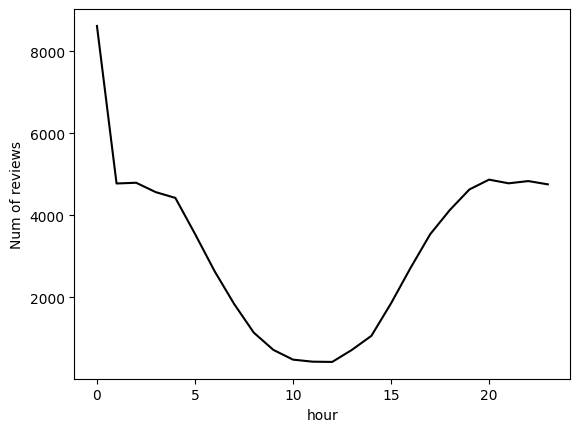

In [92]:
plt.plot((review_count["hr"]), review_count["num_reviews"], color="black")
plt.xlabel("hour")
plt.ylabel("Num of reviews")
# plt.legend()
plt.show()

#### Write to csv df_ca

In [93]:
df_ca.to_csv("df_ca.csv", index=True)

### Text Analysis

In [ ]:
df_ca.isnull().values.any()

In [ ]:
df_ca["reviewText"].isnull().values.any()

In [ ]:
import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

In [97]:
#random check
data_ca_[10589]

{'rating': 4.0,
 'reviewerName': 'James Kemp',
 'reviewText': 'It is what it. If you like Hot Wings then you will love the wings here. Its a great place to drink beers and eat wings while watching a game.    If you think you will be bother by the waitresses, then skip it.',
 'categories': ['American Restaurant'],
 'gPlusPlaceId': '109523534701774622111',
 'unixReviewTime': 1328231379,
 'reviewTime': 'Feb 2, 2012',
 'gPlusUserId': '100923767565653432429',
 'gps': [34.072835, -117.880006],
 'price': '$$$'}

In [ ]:
TextBlob('Its a great place.').sentiment

### Data split

In [99]:
# random.shuffle(data_ca_)
tr_len = round(0.8 * len(data_ca_))
va_len = round(0.1 * len(data_ca_))
te_len = round(0.1 * len(data_ca_))

tr_03 = data_ca_[0:tr_len]
va_03 = data_ca_[tr_len : tr_len + va_len]
te_03 = data_ca_[tr_len + va_len :]

len(tr_03), len(va_03), len(te_03)

(61003, 7625, 7626)

### Having two features - proportions of positive and negative sentence types in review text -> rating - This is the first model in model-03.ipynb
Ignoring the reviews which can't be split into sentences.

### Function MSE and MAE

In [103]:
def MSE(predictions, labels):
    differences = [(x - y) ** 2 for x, y in zip(predictions, labels)]
    return sum(differences) / len(differences)
def MAE(predictions, labels):
    diff = [abs(x-y) for x, y in zip(predictions, labels)]
    return sum(diff)/ len(diff)

### Having two features - proportions of positive and negative sentence types in review text - Extension 1
Modification - Considering all the reviews which can't be split into sentences

In [104]:
for i in range(0, len(data_ca_)):
    data_ca_[i].update({'reviewLength':len(data_ca_[i]['reviewText'])})
    data_ca_[i].update({'reviewHour':int(datetime.utcfromtimestamp(data_ca_[i]['unixReviewTime']).strftime('%Y-%m-%d %H:%M:%S')[11:13])})
    data_ca_[i].update({'priceRank':1 if data_ca_[i]['price'] == ['$'] else 2 if data_ca_[i]['price'] == ['$$'] else 3})

In [105]:
# It takes a while
for d in data_ca_:
    t = d['reviewText']
    d['sentences'] = split_into_sentences(t)
    #print(len(d['sentences']))
    d['sentiments'] = []
    if len(d['sentences']) == 0:
        d['sentiments'].append(TextBlob(t).sentiment[0])
    else:
        for each in d['sentences']:
            d['sentiments'].append(TextBlob(each).sentiment[0])

In [106]:
#TextBlob(data_ca_[0]['reviewText']).sentiment
data_ca_[6]
#en(data_ca[0]['sentences'])

{'rating': 5.0,
 'reviewerName': 'William Corcuera',
 'reviewText': 'I live in sandiego its about an hour drive and every time we go its worth it to the last bite. Yummm. Wish their was one closer.',
 'categories': ['Chicken Restaurant'],
 'gPlusPlaceId': '101959623187827102951',
 'unixReviewTime': 1388002613,
 'reviewTime': 'Dec 25, 2013',
 'gPlusUserId': '100000122158721897485',
 'gps': [33.680515, -117.90633],
 'price': '$$$',
 'reviewLength': 128,
 'reviewHour': 20,
 'priceRank': 3,
 'sentences': ['I live in sandiego its about an hour drive and every time we go its worth it to the last bite.',
  'Yummm.',
  'Wish their was one closer.'],
 'sentiments': [0.14545454545454545, 0.0, 0.0]}

In [107]:
len([d for d in data_ca_ if len(d['sentiments']) == 0])

0

In [108]:
# New features proportion of positive and negative sentiments in a sentence
def feature(datum):
    feat = []
    feat.append(1)
    
    count_pos = 0
    count_neg = 0
    for l in datum['sentiments']:
        if l > 0:
            count_pos+=1
        else:
            count_neg+=1

    pos_prop = count_pos/len(datum['sentiments'])
    feat.append(pos_prop)

    neg_prop = count_neg/len(datum['sentiments'])
    feat.append(neg_prop)
    #feat.append(datum['reviewLength'])
    #for l in datum['hotHour'] + datum['hotPrice'] + datum['hotSentiment']:
        #feat.append(l)
    return feat

In [109]:
X = [feature(d) for d in tr_03]
y = [d["rating"] for d in tr_03]
len(X), len(y)

(61003, 61003)

In [110]:
X[:5]

[[1, 1.0, 0.0],
 [1, 0.6666666666666666, 0.3333333333333333],
 [1, 1.0, 0.0],
 [1, 1.0, 0.0],
 [1, 0.0, 1.0]]

In [111]:
clf = linear_model.Ridge(1.0, fit_intercept=False)  # MSE + 1.0 l2
clf.fit(X, y)
theta = clf.coef_
pred = clf.predict(X)

In [112]:
theta

array([2.52278598, 1.94826466, 0.57452132])

In [113]:
pred[:5]

array([4.47105064, 4.01313619, 4.47105064, 4.47105064, 3.0973073 ])

In [114]:
any(value > 5  for value in pred)

False

In [115]:
X_va_03 = [feature(d) for d in va_03]
y_va_03 = [d["rating"] for d in va_03]

X_te_03 = [feature(d) for d in te_03]
y_te_03 = [d["rating"] for d in te_03]

pred_va_03 = clf.predict(X_va_03)
pred_te_03 = clf.predict(X_te_03)

MSE(pred, y), MSE(pred_va_03, y_va_03), MSE(pred_te_03, y_te_03)

(1.2082718137842923, 1.1956240262359328, 1.1884665803607792)

In [116]:
MAE(pred, y), MAE(pred_va_03, y_va_03), MAE(pred_te_03, y_te_03)

(0.8997376768561165, 0.8964132982646773, 0.8889989457665072)

### Having two features - proportions of positive and negative sentence types in review text along with hour, length, price (encoded) - Extension 2 

In [117]:
# New features proportion of positive and negative sentiments in a sentence
def feature(datum):
    feat = []
    feat.append(1)
    
    count_pos = 0
    count_neg = 0
    for l in datum['sentiments']:
        if l > 0:
            count_pos+=1
        else:
            count_neg+=1

    pos_prop = count_pos/len(datum['sentiments'])
    feat.append(pos_prop)

    neg_prop = count_neg/len(datum['sentiments'])
    feat.append(neg_prop)
    feat.append(datum['reviewLength'])
    feat.append(datum['priceRank'])
    feat.append(datum['reviewHour'])
    
    #for l in datum['hotHour'] + datum['hotPrice'] + datum['hotSentiment']:
        #feat.append(l)
    return feat

In [118]:
X = [feature(d) for d in tr_03]
y = [d["rating"] for d in tr_03]
len(X), len(y)

(61003, 61003)

In [119]:
X[:5]

[[1, 1.0, 0.0, 33, 3, 0],
 [1, 0.6666666666666666, 0.3333333333333333, 838, 3, 19],
 [1, 1.0, 0.0, 69, 3, 0],
 [1, 1.0, 0.0, 74, 3, 19],
 [1, 0.0, 1.0, 105, 3, 1]]

In [120]:
clf = linear_model.Ridge(1.0, fit_intercept=False)  # MSE + 1.0 l2
clf.fit(X, y)
theta = clf.coef_
pred = clf.predict(X)

In [121]:
theta

array([ 3.69854549e-01,  8.36791235e-01, -4.66936686e-01, -5.97566567e-04,
        1.10956365e+00,  3.14424366e-03])

In [122]:
pred[:5]

array([4.51561703, 3.6597406 , 4.49410463, 4.55085743, 3.17200856])

In [123]:
any(value > 5  for value in pred)

False

In [124]:
X_va_03 = [feature(d) for d in va_03]
y_va_03 = [d["rating"] for d in va_03]

X_te_03 = [feature(d) for d in te_03]
y_te_03 = [d["rating"] for d in te_03]

pred_va_03 = clf.predict(X_va_03)
pred_te_03 = clf.predict(X_te_03)

MSE(pred, y), MSE(pred_va_03, y_va_03), MSE(pred_te_03, y_te_03)

(1.179662567510621, 1.1709702072729746, 1.162421112704045)

In [125]:
MAE(pred, y), MAE(pred_va_03, y_va_03), MAE(pred_te_03, y_te_03)

(0.8912689563801814, 0.888576854644746, 0.8830185124086173)

### Advanced model - f(word vector, proportion of postive sentiment, proportion of negative sentiment, hour, length, price) -> rating

In [126]:
stop_words = stopwords.words('english')

In [127]:
len(stop_words)

179

In [128]:
wordCount = defaultdict(int)
totalWords = 0
punct = string.punctuation
#stemmer = PorterStemmer()

for d in data_ca_:
    t = d['reviewText']
    t = t.lower() # lowercase string
    t = [c for c in t if not (c in punct)] # non-punct characters
    t = ''.join(t) # convert back to string
    words = t.strip().split() # tokenizes
    for w in words:
        if w not in stop_words:
            #w = stemmer.stem(w)
            totalWords += 1
            wordCount[w] += 1

In [129]:
totalWords

1623179

In [130]:
len(wordCount)

60413

In [75]:
#wordCount

In [131]:
counts = [(wordCount[w] , w) for w in wordCount]

In [132]:
counts.sort(reverse=True)
counts[:5]

[(32377, 'food'),
 (23508, 'good'),
 (23220, 'great'),
 (20894, 'place'),
 (18005, 'service')]

In [133]:
len(counts)

60413

In [134]:
words = [w[1] for w in counts[:1000]]

In [135]:
len(words)

1000

In [136]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [137]:
# wordId

{'food': 0,
 'good': 1,
 'great': 2,
 'place': 3,
 'service': 4,
 'like': 5,
 'best': 6,
 'go': 7,
 'get': 8,
 'one': 9,
 'time': 10,
 'love': 11,
 'really': 12,
 'back': 13,
 'always': 14,
 'would': 15,
 'nice': 16,
 'restaurant': 17,
 'dont': 18,
 'pizza': 19,
 'order': 20,
 'staff': 21,
 'friendly': 22,
 'even': 23,
 'people': 24,
 'delicious': 25,
 'also': 26,
 'never': 27,
 'excellent': 28,
 'ive': 29,
 'well': 30,
 'got': 31,
 'ever': 32,
 'us': 33,
 'chicken': 34,
 'eat': 35,
 'amazing': 36,
 'better': 37,
 'little': 38,
 'try': 39,
 'store': 40,
 'come': 41,
 'went': 42,
 'wait': 43,
 'menu': 44,
 'make': 45,
 'fresh': 46,
 'im': 47,
 'bad': 48,
 'pretty': 49,
 'going': 50,
 'awesome': 51,
 'much': 52,
 'ordered': 53,
 'experience': 54,
 'price': 55,
 'way': 56,
 'bar': 57,
 'recommend': 58,
 'didnt': 59,
 'atmosphere': 60,
 'know': 61,
 'first': 62,
 'could': 63,
 'want': 64,
 'definitely': 65,
 'customer': 66,
 'lunch': 67,
 'favorite': 68,
 'prices': 69,
 'came': 70,
 'coffe

In [138]:
len(wordId)

1000

In [139]:
len(wordSet)

1000

In [140]:
def feature(datum):
    feat = [0]*len(wordSet)

    # appending word vector
    t = datum['reviewText']
    t = t.lower()
    t = [c for c in t if not (c in punct)]
    t = ''.join(t)
    words = t.strip().split()
    for w in words:
        if not (w in wordSet): continue
        feat[wordId[w]] += 1
    
    # appending sentiment features
    count_pos = 0
    count_neg = 0
    for l in datum['sentiments']:
        if l > 0:
            count_pos+=1
        else:
            count_neg+=1

    pos_prop = count_pos/len(datum['sentiments'])
    feat.append(pos_prop)

    neg_prop = count_neg/len(datum['sentiments'])
    feat.append(neg_prop)
    feat.append(datum['reviewLength'])
    feat.append(datum['priceRank'])
    feat.append(datum['reviewHour'])
    feat.append(1)
    
    #for l in datum['hotHour'] + datum['hotPrice'] + datum['hotSentiment']:
        #feat.append(l)
    return feat

In [141]:
X = [feature(d) for d in tr_03]
y = [d["rating"] for d in tr_03]
len(X), len(y)

(61003, 61003)

In [142]:
X[-20][-10:], len(X[0])

([0, 0, 0, 0, 0.0, 1.0, 141, 3, 16, 1], 1006)

In [143]:
clf = linear_model.Ridge(1.0, fit_intercept=False)  # MSE + 1.0 l2
clf.fit(X, y)
theta = clf.coef_
pred = clf.predict(X)

In [144]:
theta

array([-0.01488728, -0.00322645,  0.20240514, ...,  1.08555955,
        0.00124778,  0.36185318])

In [145]:
pred[:5]

array([4.45639671, 4.72189269, 4.60770784, 4.0431219 , 3.45924585])

In [146]:
any(value > 5  for value in pred), sum([value > 5  for value in pred]),# [value for value in pred if value > 5][:5]

(True, 2359)

In [147]:
X_va_03 = [feature(d) for d in va_03]
y_va_03 = [d["rating"] for d in va_03]

X_te_03 = [feature(d) for d in te_03]
y_te_03 = [d["rating"] for d in te_03]

pred_va_03 = clf.predict(X_va_03)
pred_te_03 = clf.predict(X_te_03)

MSE(pred, y), MSE(pred_va_03, y_va_03), MSE(pred_te_03, y_te_03)

(0.8010281586224948, 0.8365190327746289, 0.8159914139230752)

In [148]:
MAE(pred, y), MAE(pred_va_03, y_va_03), MAE(pred_te_03, y_te_03)

(0.7120467802135662, 0.7251433744435974, 0.7139347406771677)